Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/04_Classification'
except ImportError as e:
    pass

# More Classification & Evaluation

In this exercise we will look at classification again and have a closer look at evaluation.

In [ ]:
import pandas as pd
from sklearn import preprocessing

# load the data
iris = pd.read_csv("iris.csv")
iris_data = iris[['SepalLength','SepalWidth','PetalLength','PetalWidth']]

label_encoder = preprocessing.LabelEncoder()
iris_target = label_encoder.fit_transform(iris['Name'])

display(iris_data.head())
iris_target[:5]

## Cross Validation

[Cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) splits your dataset into n *folds* and then runs the learning and evaluation n times.
This gives you a better estimate of the actual performance of your classifier than a single train/test split.

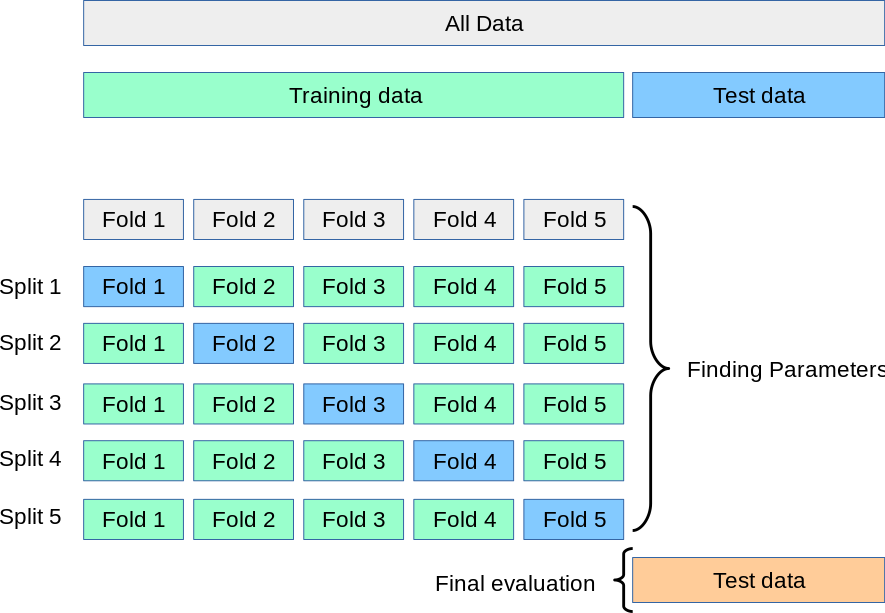

https://scikit-learn.org/stable/modules/cross_validation.html

You can evaluate any estimator with cross validation by importing the [```cross_val_score()``` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).
You specify the [evaluation measure](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) using the `scoring` parameter.
Possible values are 'accuracy', 'f1_micro', or 'f1_macro', etc.
The return value contains the score for every fold.

Note: The ```cross_val_score()``` function only evaluates the estimator on your dataset, it does not produce a model that you can apply!
To create such a model you must still call the ```fit()``` function of your estimator!

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

accuracy_iris = cross_val_score(dt, iris_data, iris_target, cv=10, scoring='accuracy')

for i, acc in enumerate(accuracy_iris):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_iris.mean() * 100.0))

### Stratified Sampling in Cross Validation

You can control how the folds are created by changing the ```cv``` parameter.
Stratified sampling is implemented in the [```StatifiedKFold``` class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [ ]:
from sklearn.model_selection import StratifiedKFold

cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_iris = cross_val_score(dt, iris_data, iris_target, cv=cross_val, scoring='accuracy')
accuracy_iris.mean()

### Obtaining predictions by cross-validation

If you want to analyse the predictions made during cross validation (for error analysis, you don't apply cross validation when actually applying the model!), you can use the [```cross_val_predict()``` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html).
Note: As the folds of a cross validation are non-overlapping, you get exactly one prediction for every example in your dataset.

In [ ]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(dt, iris_data, iris_target, cv=10)

display(predicted)


## Pipelines

A [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) in scikit-learn allows you to specify a sequence of transforms and a final estimator that can be executed and cross-validated.
This way you don't have to worry about applying the preprocessing steps (transforms) properly to each training and test split.

You create a pipeline by defining the steps that should be executed as a list.
Each element of the list is a tuple that consists of a name and the transform or estimator.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

transform = StandardScaler()
estimator = KNeighborsClassifier(n_neighbors=4)

pipeline = Pipeline([ ('normalisation', transform), ('classification', estimator) ])

accuracy_iris = cross_val_score(pipeline, iris_data, iris_target, cv=10, scoring='accuracy')

print("Average Accuracy = {}%".format(accuracy_iris.mean() * 100.0))

You can access the parameters of every element in the pipeline by using the name you assigned to the element, followed by ```'__'``` (two underscores!) and the name of the parameter.

The following code changes the ```n_neighbors``` parameter of the KNN classifier in our pipeline:

In [ ]:
pipeline.set_params(classification__n_neighbors=1) 

accuracy_iris = cross_val_score(pipeline, iris_data, iris_target, cv=10, scoring='accuracy')

print("Average Accuracy = {}%".format(accuracy_iris.mean() * 100.0))

### [Mixed feature transformation in Pipelines](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

If your dataset contains mixed feature types, you might want to apply different preprocessing steps to different sets of columns.
In this case, the [```ColumnTransformer``` class](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) comes in handy.
It allows you to specify different pipelines for different sets of features that handle the preprocessing.

The following code example applies the ```StandardScaler``` to the features 'Temperature' and 'Humidity' and the ```OneHotEncoder``` to the features 'Outlook' and 'Wind':

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# load a dataset
golf = pd.read_csv('golf.csv')
golf_target = golf['Play']
golf = golf.drop(columns='Play')
display(golf.head())

# create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # use StandardScaler for Temperature and Humidity
        ('scaler', StandardScaler(), ['Temperature', 'Humidity']),
        # use OneHotEncoder for Outlook and Wind
        ('encoder', OneHotEncoder(), ['Outlook', 'Wind']) ])

# call fit_transform to see the result of applying the ColumnTransformer
preprocessed = pd.DataFrame(preprocessor.fit_transform(golf))
display(preprocessed.head())

# define a pipeline that contains the ColumnTransformer
pipeline = Pipeline([ ('preprocessing', preprocessor), ('classification', estimator) ])

# cross validate the pipeline
# NOTE: we pass the original datasets as parameters, the pipeline handles preprocessing!
accuracy = cross_val_score(pipeline, golf, golf_target, cv=2, scoring='accuracy')
display(accuracy.mean())

## Balancing

If the classes in your training set are highly imbalanced, this can affect the model that is learned, as a much higher importance is given to the frequent class (also called majority class).
To prevent this, you can use balancing to change the class distribution **on the training set** (and only there!).

Methods for balancing are provided by the [imblearn package](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.pipeline.Pipeline.html):
- Undersampling of majority class: For example using the [```RandomUnderSampler``` class](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html)
- Oversampling of the minority class(es): For example using the [```RandomOverSampler``` class](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html)

Every sampler from this package provides a ```fit_resample()``` function that balances the data.

To find out if your data is imbalanced, it can be useful to plot the class distribution:

In [ ]:
%pip install -q -U imbalanced-learn
import matplotlib.pyplot as plt

iris = pd.read_csv("iris_imbalanced.csv")
iris_data = iris[['SepalLength','SepalWidth','PetalLength','PetalWidth']]
iris_target = iris['Name']

class_dist = iris_target.value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

The plot shows that the class 'Iris-virginica' is much more frequent than the other two classes.
We can balance the data using undersampling of this majority class:

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler()
iris_balanced_data, iris_balanced_target = sampler.fit_resample(iris_data, iris_target)

class_dist = pd.Series(iris_balanced_target).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

As an alternative to undersampling, we can also choose to oversample the minority classes:

In [ ]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()
iris_balanced_data, iris_balanced_target = sampler.fit_resample(iris_data, iris_target)

class_dist = pd.Series(iris_balanced_target).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

### Pipelines with balancing

To support the balancing methods from the imblearn package, we must create a different type of pipeline:

In [ ]:
from imblearn.pipeline import Pipeline

sampler = RandomUnderSampler()

pipeline = Pipeline([ ('normalisation', transform), ('balancing', sampler), ('classification', estimator) ])

accuracy_iris = cross_val_score(pipeline, iris_data, iris_target, cv=10, scoring='accuracy')

print("Average Accuracy = {}%".format(accuracy_iris.mean() * 100.0))

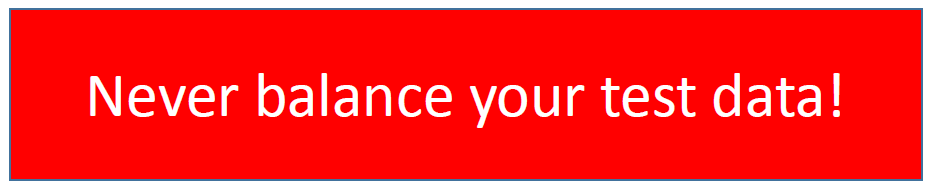

### Try it out
- Task 4.1.1
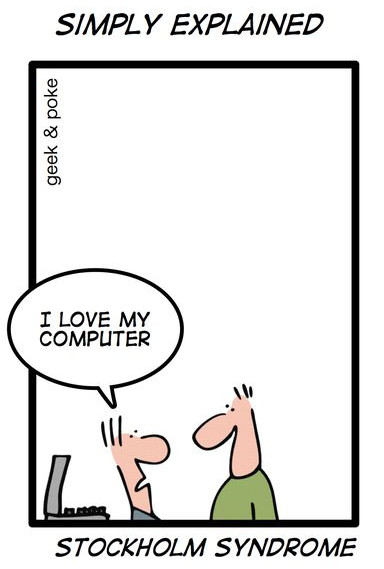
http://geek-and-poke.com/geekandpoke/2010/10/24/simply-explained.html

### Evaluation Measures: Precision and Recall
- Measure two aspects of the result for every class
- Precision: How many of the examples that were labelled “yes” are really “yes”?
    - “the number of correctly labelled examples divided by the number of all examples that were labelled with this class”
- Recall: How many of the examples that are really “yes” were labelled “yes’?
    - “the number of correctly labelled examples divided by the number of all examples that actually belong to this class”
- F1 score: considers both precision and recall (harmonic mean) 

$Precision = \frac{TP}{TP+\textbf{FP}}$
$Recall = \frac{TP}{TP+\textbf{FN}}$

$F1 = \frac{2 * precicion * recall}{precision + recall}$

In [ ]:
predicted = cross_val_predict(KNeighborsClassifier(3), iris_data, iris_target, cv=10)

from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(iris_target, predicted, target_names=label_encoder.classes_))

### Manual Cross Validation 
If you want to implement cross validation yourself, you can iterate over the folds manually:

In [ ]:
# sometimes you have to use the raw array and not the pandas dataframe (access it with .values)
data = iris_data.values 
target = iris['Name']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_indices, test_indices in cv.split(data, target):
    display(test_indices)
    
    train_data = data[train_indices]
    train_target = target[train_indices]
    
    dt.fit(train_data, train_target)

    test_data = data[test_indices]
    test_target = target[test_indices]
    
    test_prediction = dt.predict(test_data)

## Visual Evaluation

To evaluate and compare different classifiers, it can be useful to look at the ROC Curves.
You can create these curves using the [```roc_curve()``` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).
As the ROC Curves depend on the confidences of each prediction made by the classifier, you need to call the ```predict_proba()``` function, which returns the confidence values for each class, instead of the ```predict()``` function, which returns the actual prediction.

In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# load the dataset
data = pd.read_csv('weighting.csv')
target = data['weighting.dat (7)']
data = data.drop(columns='weighting.dat (7)')

# create the classifier
knn_estimator = KNeighborsClassifier(3)

# create a train/test split
data_train, data_test, target_train, target_test = train_test_split(data, target)

# fit to the training data
knn_estimator.fit(data_train, target_train)

# get the class probabilities (confidences) for the test set
proba_for_each_class = knn_estimator.predict_proba(data_test)

# calculate the ROC Curve
fpr, tpr, thresholds = roc_curve(target_test, proba_for_each_class[:,1], pos_label='positive')

# plot the line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)

# plot the ROC Curve for the classifier
plt.plot(fpr,tpr,label='K-NN')

# show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show() 

### ROC Curves with Cross Validation

To draw ROC Curves for the results of a cross validation, you can use the following function:

In [ ]:
from numpy import interp
from sklearn.metrics import roc_curve, auc
import numpy as np

def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []    
    for train_indices, test_indices in cv.split(data, target):
        train_data, train_target = data[train_indices], target[train_indices]
        estimator.fit(train_data, train_target)
        
        test_data, test_target = data[test_indices], target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data)
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1], pos_label=pos_label)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] accesses the last element
        aucs.append(auc(fpr, tpr))
        # plt.plot(fpr, tpr)  # plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    return mean_fpr, mean_tpr, mean_auc, std_auc

You apply this function as follows:

In [ ]:
# create the classifier
knn_estimator = KNeighborsClassifier(3)

# specify how to create the folds for the cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42, )

# run cross validation and calculate the ROC Curve
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator, data.values, target, 'positive')

# plot the line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)

# plot the ROC Curve for the classifier
plt.plot(mean_fpr, mean_tpr, label='K-NN')

# show the plot
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Inspect intermediate results in Pipelines
It is sometimes useful to temporarily add a debugging step that prints out the information you are interested in.

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        #TODO: define here your inspection code like printing the dataframe
        display(pd.DataFrame(X).head())
        return X

    def fit(self, X, y=None, **fit_params):
        return self

transform = StandardScaler()
estimator = KNeighborsClassifier()

# TODO: add a debug step in the pipeline
pipeline = Pipeline([ ('normalisation', transform), ('dbg', Debug()), ('classification', estimator)])
pipeline.fit(iris_data, iris_target);